# ***Install Libs***

In [1]:
dry_run = False
!pip install ../input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install ../input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl

Processing /kaggle/input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
  Attempting uninstall: kornia
    Found existing installation: kornia 0.5.8
    Uninstalling kornia-0.5.8:
      Successfully uninstalled kornia-0.5.8
Processing /kaggle/input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl


# ***Import dependencies***

In [2]:
import os
import numpy as np
import cv2
import csv
from glob import glob
import torch
from torch import nn
import matplotlib.pyplot as plt
import kornia
from kornia_moons.feature import *
import kornia as K
import kornia.feature as KF
import gc
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
LONGEST_EDGE = 840

# ***Model***

In [3]:
import sys
sys.path.append('/kaggle/input/dkm-models/DKM/')
'''
!cp -r /kaggle/input/einops .
%cd /kaggle/working/einops
!pip install -e . --no-index --no-deps
%cd /kaggle/working
sys.path.insert(0, "/kaggle/working/einops")
import einops

!mkdir -p pretrained/checkpoints
!cp /kaggle/input/DKM-pretrained-weights/dkm_base_v11.pth pretrained/checkpoints/dkm_base_v11.pth

!cp -r /kaggle/input/DKM-new/ /kaggle/working/DKM/
!cd /kaggle/working/DKM/; pip install -e . 
'''


!mkdir -p pretrained/checkpoints
!cp /kaggle/input/dkm-models/pretrained/dkm.pth pretrained/checkpoints/dkm_base_v11.pth

!pip install -f /kaggle/input/dkm-models/wheels --no-index einops
!cp -r /kaggle/input/dkm-models/DKM/ /kaggle/working/DKM/
!cd /kaggle/working/DKM/; pip install -f /kaggle/input/dkm-models/wheels -e . 


Looking in links: /kaggle/input/dkm-models/wheels
Processing /kaggle/input/dkm-models/wheels/einops-0.4.1-py3-none-any.whl
Looking in links: /kaggle/input/dkm-models/wheels
Obtaining file:///kaggle/working/DKM
  Preparing metadata (setup.py) ... - done
  Running setup.py develop for dkm


In [4]:
'''
from DKM.dkm.models import dkm_base
model = dkm_base(pretrained=True, version="v11").to(device).eval()
'''
device = torch.device('cuda')
torch.hub.set_dir('/kaggle/working/pretrained/')
from dkm import dkm_base
model = dkm_base(pretrained=True, version="v11").to(device).eval()

In [5]:

matcher = KF.LoFTR(pretrained=None)
matcher.load_state_dict(torch.load("../input/kornia-loftr/loftr_outdoor.ckpt")['state_dict'])
matcher = matcher.to(device).eval()

# segformer backbone mit-b3 fine tuned on cityscapes image size-1024x1024
model_name = "/kaggle/input/segformer-mit-b3-cityscapes"
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)
model_seg = SegformerForSemanticSegmentation.from_pretrained(model_name)
model_seg = model_seg.to(device)

## *Utils*

In [6]:
src = '/kaggle/input/image-matching-challenge-2022/'

test_samples = []
with open(f'{src}/test.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        test_samples += [row]


def FlattenMatrix(M, num_digits=8):
    '''Convenience function to write CSV files.'''
    
    return ' '.join([f'{v:.{num_digits}e}' for v in M.flatten()])

def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

def resize_keep_ratio(img, longest_size=1028):
    height, width,c = img.shape
    if np.maximum(height, width) <= longest_size: # no need to resize
        return img
    
    if height >= width:
        resized_img = imutils.resize(img, height=longest_size)
    else:
        resized_img = imutils.resize(img, width=longest_size)
    return resized_img

def load_torch_image(fname, device):
    img = cv2.imread(fname)
    #img = resize_keep_ratio(img)
    scale = 840 / max(img.shape[0], img.shape[1]) 
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    #img = cv2.resize(img, (w, h))
    img = cv2.resize(img, (img.shape[1]//8*8, img.shape[0]//8*8))  # input size should be divisible by 8
    #img = white_balance(img)
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img.to(device)

def load_torch_image_green_channel(fname, device):
    img = cv2.imread(fname)
    scale = 840 / max(img.shape[0], img.shape[1]) 
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    #img = cv2.resize(img, (w, h))
    img = cv2.resize(img, (img.shape[1]//8*8, img.shape[0]//8*8))  # input size should be divisible by 8
    #img = white_balance(img)
    img = img[:,:,1]
    img = K.image_to_tensor(img, False).float() /255.
    #img = K.color.bgr_to_rgb(img)
    return img.to(device)

def load_image(fname):
    img = cv2.imread(fname)
    scale = 840 / max(img.shape[0], img.shape[1]) 
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    #img = cv2.resize(img, (w, h))
    img = cv2.resize(img, (img.shape[1]//8*8, img.shape[0]//8*8))  # input size should be divisible by 8
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img


'''
Cityscapes classes(n=19)
CLASSES = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 
                'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']

'''

def cityscapes_bin_palette():
    return [[0, 0, 0],[0, 0, 0],[255, 255, 255],[255, 255, 255],
            [255, 255, 255],[255, 255, 255],[255, 255, 255],[255, 255, 255],
            [255, 255, 255],[0, 0, 0],[0, 0, 0],[0, 0, 0],[0, 0, 0],
            [0, 0, 0],[0, 0, 0],[0, 0, 0],[0, 0, 0],[0, 0, 0],
            [0, 0, 0]]

kernel_mask_sky = np.ones((5, 5), np.uint8)
kernel_mask_other_classes = np.ones((3, 3), np.uint8)

def semantic_segmentation_inference(image,device):
    image = torch.from_numpy(cv2.resize(image,(1024,1024)))
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    outputs = model_seg(**inputs)
      
    # First, rescale logits to original image size
    logits = nn.functional.interpolate(outputs.logits.detach().cpu(),
                    size=image[:,:,-1].shape, # (height, width)
                    mode='bilinear',
                    align_corners=False)
    
    # Second, apply argmax on the class dimension
    seg = logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(cityscapes_bin_palette())
    
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    
    return color_seg

def semantic_segmentation_inference_with_mask_erosion(image,device):
    image = torch.from_numpy(cv2.resize(image,(1024,1024)))
    inputs = feature_extractor(images=image, return_tensors="pt").to(device)
    outputs = model_seg(**inputs)
      
    # First, rescale logits to original image size
    logits = nn.functional.interpolate(outputs.logits.detach().cpu(),
                    size=image[:,:,-1].shape, # (height, width)
                    mode='bilinear',
                    align_corners=False)
    
    # Second, apply argmax on the class dimension
    seg = logits.argmax(dim=1)[0]
    color_seg_eroded =  np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    color_seg_mask_sky = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    color_seg_mask_other_classes = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(cityscapes_bin_palette())
    
    for label, color in enumerate(palette):
        if label==10:
            color_seg_mask_sky[seg==label,:] = [255,255,255]
        elif not np.any(color) and label!=10:
            color_seg_mask_other_classes[seg==label,:] = [255,255,255]
            
    color_seg_mask_sky = cv2.erode(color_seg_mask_sky,kernel_mask_sky)
    color_seg_mask_other_classes = cv2.erode(color_seg_mask_other_classes,kernel_mask_other_classes)
    color_seg_eroded = cv2.bitwise_or(color_seg_mask_sky,color_seg_mask_other_classes)
    color_seg_eroded = cv2.bitwise_not(color_seg_eroded)
    return color_seg_eroded

def rotate_image_tensor(x_img,ang):
    alpha = float(ang)  # in degrees
    angle = (torch.ones(1) * alpha).to(device)

    # define the rotation center
    center = torch.ones(1, 2).to(device)
    w = x_img.shape[3]
    h = x_img.shape[2]
    center[:, 0] =  w/ 2  # x
    center[:, 1] =  h/ 2  # y

    # define the scale factor
    scale = torch.ones(1, 2).to(device)

    # compute the transformation matrix
    M = K.geometry.get_rotation_matrix2d(center, angle, scale).to(device)  # 1x2x3
    x_warped = K.geometry.warp_affine(x_img, M, dsize=(h, w))
    return x_warped.to(device)

def slope_to_angle(x1,y1,x2,y2):
    slope = (y2-y1)/(x2-x1)
    angle = math.degrees(math.atan(slope))  
    return angle


# ***Inference***

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


inliers: 1219
Running time:  9.564122200012207  s
inliers: 936
Running time:  2.0007810592651367  s
inliers: 279
Running time:  3.8348000049591064  s


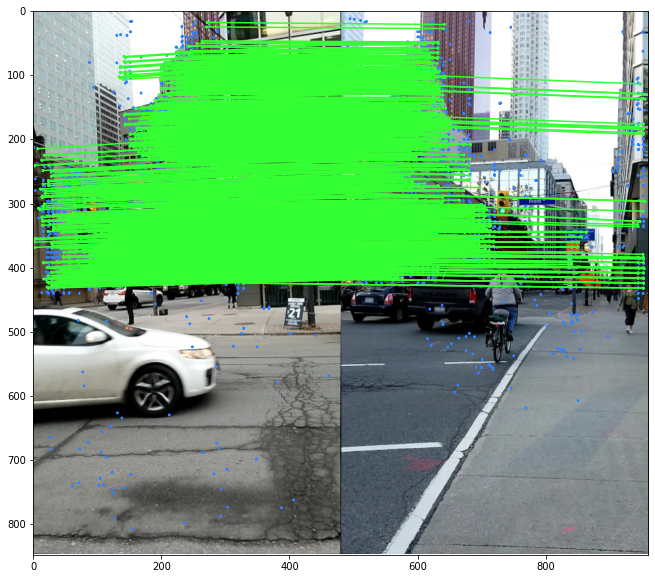

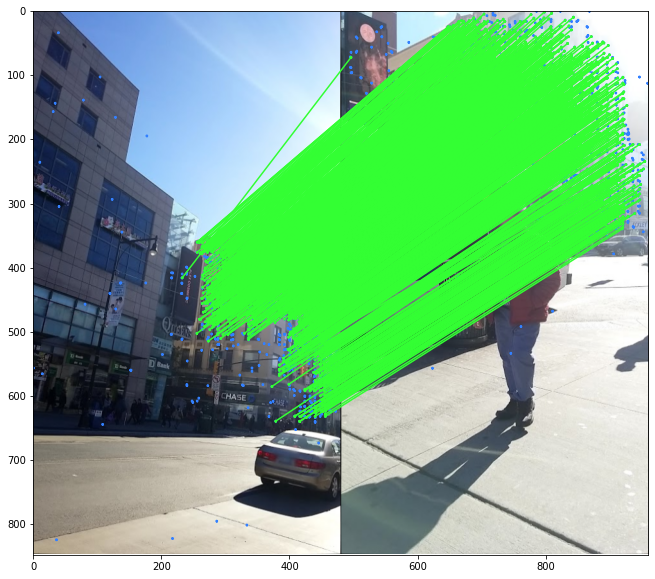

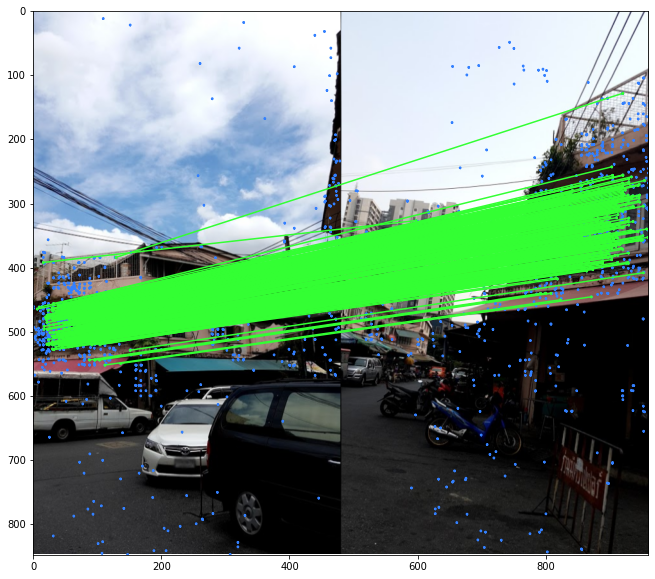

In [7]:
F_dict = {}
import time
for i, row in enumerate(test_samples):
    sample_id, batch_id, image_1_id, image_2_id = row
    # Load the images.
    st = time.time()
    
    #torch_image_g_1 = load_torch_image_green_channel(f'{src}/test_images/{batch_id}/{image_1_id}.png',device)
    #torch_image_g_2 = load_torch_image_green_channel(f'{src}/test_images/{batch_id}/{image_2_id}.png',device)
    
    torch_image_rgb_1 = load_torch_image(f'{src}/test_images/{batch_id}/{image_1_id}.png',device)
    torch_image_rgb_2 = load_torch_image(f'{src}/test_images/{batch_id}/{image_2_id}.png',device)

    
    image_rgb_1 = K.tensor_to_image(torch_image_rgb_1)
    image_rgb_2 = K.tensor_to_image(torch_image_rgb_2)
    h1, w1, _ = image_rgb_1.shape
    h2, w2, _ = image_rgb_2.shape
    
    #mask_1_bin = semantic_segmentation_inference(image_rgb_1,device)
    #mask_2_bin = semantic_segmentation_inference(image_rgb_2,device)
    mask_1_bin = semantic_segmentation_inference_with_mask_erosion(image_rgb_1,device)
    mask_2_bin = semantic_segmentation_inference_with_mask_erosion(image_rgb_2,device)
    mask_1_bin = cv2.resize(mask_1_bin,(w1,h1))
    mask_2_bin = cv2.resize(mask_2_bin,(w2,h2))
    mask_1_bin = K.color.rgb_to_grayscale((K.image_to_tensor(mask_1_bin, False).float() /255)).to(device)
    mask_2_bin = K.color.rgb_to_grayscale((K.image_to_tensor(mask_2_bin, False).float() /255)).to(device)
    
    
    #image_rgb_1 = cv2.normalize(image_rgb_1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #image_rgb_2 = cv2.normalize(image_rgb_2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #torch_image_rgb_1 = K.image_to_tensor(image_rgb_1).to(device)
    #torch_image_rgb_2 = K.image_to_tensor(image_rgb_2).to(device)
    
    '''
    masked_image_rgb_1 = torch.einsum('bchw,bghw->hwc', torch_image_rgb_1, mask_1_bin).cpu().numpy()
    masked_image_rgb_2 = torch.einsum('bchw,bghw->hwc', torch_image_rgb_2, mask_2_bin).cpu().numpy()
    '''
    
    #input_dict = {"image0": K.color.rgb_to_grayscale(torch_image_rgb_1),"image1": K.color.rgb_to_grayscale(torch_image_rgb_2)}
    #torch_image_rgb_1 = K.enhance.normalize(torch_image_rgb_1,mean_1,std_1)
    #torch_image_rgb_2 = K.enhance.normalize(torch_image_rgb_2,mean_2,std_2)
    input_dict = {"image0": K.color.rgb_to_grayscale(torch_image_rgb_1),"image1": K.color.rgb_to_grayscale(torch_image_rgb_2),"mask0":torch.squeeze(mask_1_bin,axis=0),"mask1":torch.squeeze(mask_2_bin,axis=0)}
    input_dict_2 = {"image0": K.color.rgb_to_grayscale(torch_image_rgb_2),"image1": K.color.rgb_to_grayscale(torch_image_rgb_1),"mask0":torch.squeeze(mask_2_bin,axis=0),"mask1":torch.squeeze(mask_1_bin,axis=0)}
    
    #input_dict = {"image0": torch.unsqueeze(torch_image_rgb_1[:,1,:,:],1),"image1": torch.unsqueeze(torch_image_rgb_2[:,1,:,:],1),"mask0":torch.squeeze(mask_1_bin,axis=0),"mask1":torch.squeeze(mask_2_bin,axis=0)}
    #input_dict_2 = {"image0": torch.unsqueeze(torch_image_rgb_2[:,1,:,:],1),"image1": torch.unsqueeze(torch_image_rgb_1[:,1,:,:],1),"mask0":torch.squeeze(mask_2_bin,axis=0),"mask1":torch.squeeze(mask_1_bin,axis=0)}
    
    with torch.no_grad():
        correspondences = matcher(input_dict)
        correspondences_2 = matcher(input_dict_2)
        
    rgb_mkpts0_a = correspondences['keypoints0'].cpu().numpy() # image 1
    rgb_mkpts1_a = correspondences['keypoints1'].cpu().numpy() # image 2
    mconf_a = correspondences['confidence'].cpu().numpy()
    
    rgb_mkpts0_b = correspondences_2['keypoints0'].cpu().numpy() # image 2
    rgb_mkpts1_b = correspondences_2['keypoints1'].cpu().numpy() # image 1
    mconf_b = correspondences_2['confidence'].cpu().numpy()
    
    rgb_mkpts0_L = np.concatenate((rgb_mkpts0_a,rgb_mkpts1_b))
    rgb_mkpts1_L = np.concatenate((rgb_mkpts1_a,rgb_mkpts0_b))
    mconf_L = np.concatenate((mconf_a,mconf_b))
    
    '''
    torch_image_rgb_1 = K.enhance.equalize(torch_image_rgb_1)
    torch_image_rgb_2 = K.enhance.equalize(torch_image_rgb_2)
    image_rgb_1 = K.tensor_to_image(torch_image_rgb_1)
    image_rgb_2 = K.tensor_to_image(torch_image_rgb_2)    
    '''
    image_rgb_1_uint8 = (image_rgb_1*255).astype(np.uint8)
    image_rgb_2_uint8 = (image_rgb_2*255).astype(np.uint8)
    #image_rgb_1_uint8 = (masked_image_rgb_1*255).astype(np.uint8)
    #image_rgb_2_uint8 = (masked_image_rgb_2*255).astype(np.uint8)
    img1PIL = Image.fromarray(image_rgb_1_uint8)
    img2PIL = Image.fromarray(image_rgb_2_uint8)
    
    # use latest ver from github
    dense_matches, dense_certainty = model.match(img1PIL, img2PIL, check_cycle_consistency=False, do_pred_in_og_res=True)
    #dense_matches, dense_certainty = model.match(img1PIL, img2PIL)
    
    dense_certainty = dense_certainty.sqrt()
    sparse_matches, sparse_certainty = model.sample(dense_matches, dense_certainty, 500)
    
    #sparse_matches, sparse_certainty = model.sample(dense_matches, dense_certainty, 10000)
    
    mkpts0_D = sparse_matches[:, :2]
    mkpts1_D = sparse_matches[:, 2:]
    
   
    mkpts0_D[:, 0] = ((mkpts0_D[:, 0] + 1)/2) * w1
    mkpts0_D[:, 1] = ((mkpts0_D[:, 1] + 1)/2) * h1

    
    mkpts1_D[:, 0] = ((mkpts1_D[:, 0] + 1)/2) * w2
    mkpts1_D[:, 1] = ((mkpts1_D[:, 1] + 1)/2) * h2
    
    rgb_mkpts0 = np.concatenate((rgb_mkpts0_L,mkpts0_D),axis=0)
    rgb_mkpts1 = np.concatenate((rgb_mkpts1_L,mkpts1_D),axis=0)
    mconf = np.concatenate((mconf_L,sparse_certainty),axis=0)
    
   
    '''
    if len(rgb_mkpts0) > 7:
        # Sorted
        rgb_mkpts0 = rgb_mkpts0[np.argsort(mconf)]
        rgb_mkpts1 = rgb_mkpts1[np.argsort(mconf)]
        mconf = mconf[np.argsort(mconf)]

        # Remove Low Confidence
        rgb_mkpts0 = rgb_mkpts0[np.where(mconf>0.8)]
        rgb_mkpts1 = rgb_mkpts1[np.where(mconf>0.8)]
        mconf = mconf[np.where(mconf>0.8)]
    '''

        
    if len(rgb_mkpts0) > 7:
        
        #F, inliers = cv2.findFundamentalMat(rgb_mkpts0, rgb_mkpts1, cv2.USAC_MAGSAC, 0.4, 0.99999, 100000)
        F, inliers = cv2.findFundamentalMat(rgb_mkpts0, rgb_mkpts1, cv2.USAC_MAGSAC, 0.3, 0.99999, 100000)
        #F, inliers = cv2.findFundamentalMat(rgb_mkpts0, rgb_mkpts1, cv2.USAC_MAGSAC, 0.1845, 0.999999, 220000)
        
        
        inliers = inliers > 0
        
        assert F.shape == (3, 3), 'Malformed F?'
        F_dict[sample_id] = F
    else:
        F_dict[sample_id] = np.zeros((3, 3))
        continue
    gc.collect()
    nd = time.time()    
    if (i < 3):
        print(f"inliers: {np.count_nonzero(inliers)}")
        rgb_inliers = inliers
        print("Running time: ", nd - st, " s")
        draw_LAF_matches(
        KF.laf_from_center_scale_ori(torch.from_numpy(rgb_mkpts0).view(1,-1, 2),
                                    torch.ones(rgb_mkpts0.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(rgb_mkpts0.shape[0]).view(1,-1, 1)),

        KF.laf_from_center_scale_ori(torch.from_numpy(rgb_mkpts1).view(1,-1, 2),
                                    torch.ones(rgb_mkpts1.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(rgb_mkpts1.shape[0]).view(1,-1, 1)),
        torch.arange(rgb_mkpts0.shape[0]).view(-1,1).repeat(1,2),
        image_rgb_1_uint8,
        image_rgb_2_uint8,
        inliers,
        draw_dict={'inlier_color': (0.2, 1, 0.2),
                   'tentative_color': None, 
                   'feature_color': (0.2, 0.5, 1), 'vertical': False})
        
        
        

In [8]:
with open('submission.csv', 'w') as f:
    f.write('sample_id,fundamental_matrix\n')
    for sample_id, F in F_dict.items():
        f.write(f'{sample_id},{FlattenMatrix(F)}\n')